In [1]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.6
CUDA available?: True
Device count: 1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder
from dimensionality_reduction import DimensionalityReductionAAE

## Fixed Experiment

In [48]:
NUM_EPOCHS = 100
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 2
PRIOR_STD = 1.0
NUM_LABELED = 100
ETA = 100
LAMBDA_CH = 1
RUN = 3

RESULT_FOLDER = (
    f'dimensionality_reduction_results/'
    f'epochs_{NUM_EPOCHS}_'
    f'clusters_{LATENT_DIM_CAT}_'
    f'eta_{ETA}_'
    f'labeled_{NUM_LABELED}_'
    f'latentStyle_{LATENT_DIM_STYLE}_'
    f'run_{RUN}'
)

recon_loss = nn.MSELoss()
init_recon_lr = 0.01 #0.01


semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.1 #0.1
init_gen_lr = init_disc_lr = 0.1 #0.1
use_decoder_sigmoid = False

In [3]:
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision import datasets, transforms
import torch, numpy as np


class UnlabeledWrapper(Dataset):
    """Return images only; label is always -1."""
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, _ = self.base_ds[self.indices[i]]
        return x, -1


def configure_mnist(batch_size=100, n_labeled=1000, val_fraction=0.10, seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))          # flatten to 784
    ])

    full_train = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    rng = np.random.RandomState(seed)
    all_idx       = np.arange(len(full_train))                       # 60 000 indices
    labeled_idx   = rng.choice(all_idx, size=n_labeled, replace=False)
    remaining_idx = np.setdiff1d(all_idx, labeled_idx)

    n_val   = int(len(remaining_idx) * val_fraction)
    val_idx = rng.choice(remaining_idx, size=n_val, replace=False)
    unlabeled_idx = np.setdiff1d(remaining_idx, val_idx)

    labeled_ds     = Subset(full_train, labeled_idx)                 # (x, y)
    val_ds         = Subset(full_train, val_idx)                     # (x, y)
    unlabeled_ds   = UnlabeledWrapper(full_train, unlabeled_idx)     # (x, -1)

    if n_labeled > 0:
        train_labeled_loader = DataLoader(
            labeled_ds, batch_size=batch_size,
            shuffle=True, drop_last=True)
    else:                                                     
        train_labeled_loader = None

    train_unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader             = DataLoader(val_ds,       batch_size=batch_size, shuffle=False)
    test_loader            = DataLoader(test_ds,      batch_size=batch_size, shuffle=False)

    if n_labeled > 0:
        X_lab = torch.stack([x for x, _ in labeled_ds])
        Y_lab = torch.tensor([y for _, y in labeled_ds])
    else:                                               
        X_lab = torch.empty((0, 784))                         
        Y_lab = torch.empty((0,), dtype=torch.long)

    X_val = torch.stack([x for x, _ in val_ds])
    Y_val = torch.tensor([y for _, y in val_ds])

    X_test = torch.stack([x for x, _ in test_ds])
    Y_test = test_ds.targets.clone()

    return (X_lab, X_val, X_test,
            Y_lab, Y_val, Y_test,
            train_labeled_loader, train_unlabeled_loader, val_loader, test_loader)

In [4]:
(X_lab, X_val, X_test,
 Y_lab, Y_val, Y_test,
 train_labeled_loader,
 train_unlabeled_loader,
 val_loader,
 test_loader) = configure_mnist(batch_size=BATCH_SIZE, n_labeled=NUM_LABELED)

print("labelled   :", len(train_labeled_loader.dataset))   # 1 000
print("unlabelled :", len(train_unlabeled_loader.dataset)) # ≈53 000
print("val        :", len(val_loader.dataset))             # ≈6 000
print(Y_lab.max(), Y_lab.min())      

labelled   : 100
unlabelled : 53910
val        : 5990
tensor(9) tensor(0)


In [49]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = DimensionalityReductionAAE(options, eta=ETA, lambda_ch=LAMBDA_CH)

In [50]:
model.train_mbgd_2(
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE,
    train_labeled_loader=train_labeled_loader,
    train_unlabeled_loader=train_unlabeled_loader
)

Epoch [1/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 1/100 — Recon_U: 89.9378, Recon_L: 89.9351, SemiSup: 0.1400, Disc_Cat: 1.3856, Gen_Cat: 0.6935, Disc_Sty: 1.3766, Gen_Sty: 0.7174
[VAL]  Accuracy: 77.10%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [2/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 2/100 — Recon_U: 72.7639, Recon_L: 72.7580, SemiSup: 0.0212, Disc_Cat: 1.3813, Gen_Cat: 0.6957, Disc_Sty: 1.3589, Gen_Sty: 0.7766
[VAL]  Accuracy: 74.52%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [3/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 3/100 — Recon_U: 55.5821, Recon_L: 55.5770, SemiSup: 0.0046, Disc_Cat: 1.3782, Gen_Cat: 0.6973, Disc_Sty: 1.3795, Gen_Sty: 0.7104
[VAL]  Accuracy: 74.82%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [4/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 4/100 — Recon_U: 40.3800, Recon_L: 40.3756, SemiSup: 0.0041, Disc_Cat: 1.3705, Gen_Cat: 0.7010, Disc_Sty: 1.3760, Gen_Sty: 0.7243
[VAL]  Accuracy: 77.96%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [5/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 5/100 — Recon_U: 31.7551, Recon_L: 31.7510, SemiSup: 0.0063, Disc_Cat: 1.3607, Gen_Cat: 0.7116, Disc_Sty: 1.3649, Gen_Sty: 0.7561
[VAL]  Accuracy: 79.12%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [6/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 6/100 — Recon_U: 27.5161, Recon_L: 27.5118, SemiSup: 0.0151, Disc_Cat: 1.3408, Gen_Cat: 0.7434, Disc_Sty: 1.3463, Gen_Sty: 0.8260
[VAL]  Accuracy: 79.62%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [7/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 7/100 — Recon_U: 24.8468, Recon_L: 24.8426, SemiSup: 0.0177, Disc_Cat: 1.3530, Gen_Cat: 0.7463, Disc_Sty: 1.3742, Gen_Sty: 0.7457
[VAL]  Accuracy: 79.33%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [8/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 8/100 — Recon_U: 23.2314, Recon_L: 23.2273, SemiSup: 0.0286, Disc_Cat: 1.3638, Gen_Cat: 0.7384, Disc_Sty: 1.3813, Gen_Sty: 0.7145
[VAL]  Accuracy: 71.79%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [9/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 9/100 — Recon_U: 21.8860, Recon_L: 21.8819, SemiSup: 0.0348, Disc_Cat: 1.3710, Gen_Cat: 0.7292, Disc_Sty: 1.3876, Gen_Sty: 0.6938
[VAL]  Accuracy: 76.64%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [10/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 10/100 — Recon_U: 20.5342, Recon_L: 20.5299, SemiSup: 0.0361, Disc_Cat: 1.3732, Gen_Cat: 0.7232, Disc_Sty: 1.3861, Gen_Sty: 0.6945
[VAL]  Accuracy: 76.71%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [11/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 11/100 — Recon_U: 19.3688, Recon_L: 19.3645, SemiSup: 0.0414, Disc_Cat: 1.3725, Gen_Cat: 0.7235, Disc_Sty: 1.3864, Gen_Sty: 0.6941
[VAL]  Accuracy: 72.32%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [12/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 12/100 — Recon_U: 18.5183, Recon_L: 18.5136, SemiSup: 0.0280, Disc_Cat: 1.3747, Gen_Cat: 0.7190, Disc_Sty: 1.3734, Gen_Sty: 0.7239
[VAL]  Accuracy: 68.13%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [13/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 13/100 — Recon_U: 17.7682, Recon_L: 17.7632, SemiSup: 0.0237, Disc_Cat: 1.3721, Gen_Cat: 0.7221, Disc_Sty: 1.3763, Gen_Sty: 0.7221
[VAL]  Accuracy: 73.24%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [14/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 14/100 — Recon_U: 17.0234, Recon_L: 17.0186, SemiSup: 0.0186, Disc_Cat: 1.3727, Gen_Cat: 0.7209, Disc_Sty: 1.3848, Gen_Sty: 0.6989
[VAL]  Accuracy: 75.86%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [15/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 15/100 — Recon_U: 16.3351, Recon_L: 16.3302, SemiSup: 0.0106, Disc_Cat: 1.3675, Gen_Cat: 0.7287, Disc_Sty: 1.3750, Gen_Sty: 0.7325
[VAL]  Accuracy: 71.75%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [16/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 16/100 — Recon_U: 15.6329, Recon_L: 15.6282, SemiSup: 0.0190, Disc_Cat: 1.3699, Gen_Cat: 0.7251, Disc_Sty: 1.3832, Gen_Sty: 0.7015
[VAL]  Accuracy: 75.08%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [17/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 17/100 — Recon_U: 14.9172, Recon_L: 14.9119, SemiSup: 0.0168, Disc_Cat: 1.3690, Gen_Cat: 0.7262, Disc_Sty: 1.3762, Gen_Sty: 0.7389
[VAL]  Accuracy: 70.65%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [18/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 18/100 — Recon_U: 14.3117, Recon_L: 14.3062, SemiSup: 0.0165, Disc_Cat: 1.3705, Gen_Cat: 0.7248, Disc_Sty: 1.3782, Gen_Sty: 0.7248
[VAL]  Accuracy: 72.24%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [19/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 19/100 — Recon_U: 13.8394, Recon_L: 13.8343, SemiSup: 0.0131, Disc_Cat: 1.3691, Gen_Cat: 0.7274, Disc_Sty: 1.3810, Gen_Sty: 0.7116
[VAL]  Accuracy: 72.77%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [20/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 20/100 — Recon_U: 13.4515, Recon_L: 13.4464, SemiSup: 0.0080, Disc_Cat: 1.3713, Gen_Cat: 0.7244, Disc_Sty: 1.3808, Gen_Sty: 0.7149
[VAL]  Accuracy: 69.23%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [21/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 21/100 — Recon_U: 13.1719, Recon_L: 13.1668, SemiSup: 0.0153, Disc_Cat: 1.3687, Gen_Cat: 0.7275, Disc_Sty: 1.3852, Gen_Sty: 0.6976
[VAL]  Accuracy: 72.80%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [22/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 22/100 — Recon_U: 12.8974, Recon_L: 12.8924, SemiSup: 0.0110, Disc_Cat: 1.3683, Gen_Cat: 0.7282, Disc_Sty: 1.3787, Gen_Sty: 0.7351
[VAL]  Accuracy: 74.87%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [23/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 23/100 — Recon_U: 12.6220, Recon_L: 12.6169, SemiSup: 0.0135, Disc_Cat: 1.3673, Gen_Cat: 0.7297, Disc_Sty: 1.3788, Gen_Sty: 0.7184
[VAL]  Accuracy: 72.30%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [24/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 24/100 — Recon_U: 12.3536, Recon_L: 12.3485, SemiSup: 0.0184, Disc_Cat: 1.3690, Gen_Cat: 0.7282, Disc_Sty: 1.3803, Gen_Sty: 0.7203
[VAL]  Accuracy: 71.52%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [25/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 25/100 — Recon_U: 12.1033, Recon_L: 12.0982, SemiSup: 0.0143, Disc_Cat: 1.3677, Gen_Cat: 0.7314, Disc_Sty: 1.3786, Gen_Sty: 0.7230
[VAL]  Accuracy: 73.39%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [26/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 26/100 — Recon_U: 11.8712, Recon_L: 11.8660, SemiSup: 0.0171, Disc_Cat: 1.3673, Gen_Cat: 0.7322, Disc_Sty: 1.3770, Gen_Sty: 0.7375
[VAL]  Accuracy: 74.92%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [27/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 27/100 — Recon_U: 11.6414, Recon_L: 11.6364, SemiSup: 0.0150, Disc_Cat: 1.3704, Gen_Cat: 0.7267, Disc_Sty: 1.3833, Gen_Sty: 0.7135
[VAL]  Accuracy: 70.17%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [28/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 28/100 — Recon_U: 11.4281, Recon_L: 11.4232, SemiSup: 0.0109, Disc_Cat: 1.3718, Gen_Cat: 0.7264, Disc_Sty: 1.3763, Gen_Sty: 0.7502
[VAL]  Accuracy: 75.04%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [29/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 29/100 — Recon_U: 11.2557, Recon_L: 11.2501, SemiSup: 0.0211, Disc_Cat: 1.3698, Gen_Cat: 0.7290, Disc_Sty: 1.3788, Gen_Sty: 0.7352
[VAL]  Accuracy: 69.10%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [30/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 30/100 — Recon_U: 11.0805, Recon_L: 11.0748, SemiSup: 0.0239, Disc_Cat: 1.3670, Gen_Cat: 0.7347, Disc_Sty: 1.3763, Gen_Sty: 0.7467
[VAL]  Accuracy: 66.43%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [31/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 31/100 — Recon_U: 10.9599, Recon_L: 10.9543, SemiSup: 0.0179, Disc_Cat: 1.3635, Gen_Cat: 0.7413, Disc_Sty: 1.3787, Gen_Sty: 0.7297
[VAL]  Accuracy: 72.09%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [32/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 32/100 — Recon_U: 10.8731, Recon_L: 10.8670, SemiSup: 0.0291, Disc_Cat: 1.3599, Gen_Cat: 0.7465, Disc_Sty: 1.3768, Gen_Sty: 0.7510
[VAL]  Accuracy: 69.28%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [33/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 33/100 — Recon_U: 10.7855, Recon_L: 10.7796, SemiSup: 0.0215, Disc_Cat: 1.3655, Gen_Cat: 0.7384, Disc_Sty: 1.3767, Gen_Sty: 0.7394
[VAL]  Accuracy: 69.92%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [34/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 34/100 — Recon_U: 10.6979, Recon_L: 10.6923, SemiSup: 0.0262, Disc_Cat: 1.3652, Gen_Cat: 0.7391, Disc_Sty: 1.3775, Gen_Sty: 0.7328
[VAL]  Accuracy: 69.50%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [35/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 35/100 — Recon_U: 10.6104, Recon_L: 10.6049, SemiSup: 0.0287, Disc_Cat: 1.3676, Gen_Cat: 0.7352, Disc_Sty: 1.3761, Gen_Sty: 0.7444
[VAL]  Accuracy: 71.47%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [36/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 36/100 — Recon_U: 10.5232, Recon_L: 10.5175, SemiSup: 0.0296, Disc_Cat: 1.3629, Gen_Cat: 0.7449, Disc_Sty: 1.3736, Gen_Sty: 0.7708
[VAL]  Accuracy: 66.93%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [37/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 37/100 — Recon_U: 10.4359, Recon_L: 10.4300, SemiSup: 0.0237, Disc_Cat: 1.3620, Gen_Cat: 0.7458, Disc_Sty: 1.3760, Gen_Sty: 0.7578
[VAL]  Accuracy: 71.02%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [38/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 38/100 — Recon_U: 10.3483, Recon_L: 10.3424, SemiSup: 0.0264, Disc_Cat: 1.3655, Gen_Cat: 0.7409, Disc_Sty: 1.3770, Gen_Sty: 0.7480
[VAL]  Accuracy: 69.98%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [39/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 39/100 — Recon_U: 10.2603, Recon_L: 10.2548, SemiSup: 0.0262, Disc_Cat: 1.3656, Gen_Cat: 0.7410, Disc_Sty: 1.3768, Gen_Sty: 0.7488
[VAL]  Accuracy: 69.98%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [40/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 40/100 — Recon_U: 10.1732, Recon_L: 10.1672, SemiSup: 0.0229, Disc_Cat: 1.3641, Gen_Cat: 0.7437, Disc_Sty: 1.3761, Gen_Sty: 0.7476
[VAL]  Accuracy: 69.48%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [41/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 41/100 — Recon_U: 10.0874, Recon_L: 10.0809, SemiSup: 0.0317, Disc_Cat: 1.3617, Gen_Cat: 0.7473, Disc_Sty: 1.3756, Gen_Sty: 0.7474
[VAL]  Accuracy: 61.19%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [42/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 42/100 — Recon_U: 10.0571, Recon_L: 10.0503, SemiSup: 0.0291, Disc_Cat: 1.3551, Gen_Cat: 0.7618, Disc_Sty: 1.3696, Gen_Sty: 0.7761
[VAL]  Accuracy: 66.73%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [43/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 43/100 — Recon_U: 10.0567, Recon_L: 10.0502, SemiSup: 0.0328, Disc_Cat: 1.3604, Gen_Cat: 0.7519, Disc_Sty: 1.3736, Gen_Sty: 0.7849
[VAL]  Accuracy: 69.03%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [44/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 44/100 — Recon_U: 10.0569, Recon_L: 10.0503, SemiSup: 0.0379, Disc_Cat: 1.3612, Gen_Cat: 0.7530, Disc_Sty: 1.3696, Gen_Sty: 0.7921
[VAL]  Accuracy: 67.63%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [45/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 45/100 — Recon_U: 10.0567, Recon_L: 10.0502, SemiSup: 0.0356, Disc_Cat: 1.3593, Gen_Cat: 0.7560, Disc_Sty: 1.3702, Gen_Sty: 0.7836
[VAL]  Accuracy: 64.37%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [46/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 46/100 — Recon_U: 10.0568, Recon_L: 10.0503, SemiSup: 0.0468, Disc_Cat: 1.3556, Gen_Cat: 0.7651, Disc_Sty: 1.3678, Gen_Sty: 0.8121
[VAL]  Accuracy: 66.76%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [47/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 47/100 — Recon_U: 10.0571, Recon_L: 10.0504, SemiSup: 0.0403, Disc_Cat: 1.3591, Gen_Cat: 0.7586, Disc_Sty: 1.3736, Gen_Sty: 0.7649
[VAL]  Accuracy: 69.58%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [48/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 48/100 — Recon_U: 10.0569, Recon_L: 10.0503, SemiSup: 0.0459, Disc_Cat: 1.3571, Gen_Cat: 0.7638, Disc_Sty: 1.3649, Gen_Sty: 0.8331
[VAL]  Accuracy: 65.29%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [49/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 49/100 — Recon_U: 10.0569, Recon_L: 10.0502, SemiSup: 0.0393, Disc_Cat: 1.3598, Gen_Cat: 0.7618, Disc_Sty: 1.3714, Gen_Sty: 0.7801
[VAL]  Accuracy: 69.55%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [50/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 50/100 — Recon_U: 10.0570, Recon_L: 10.0503, SemiSup: 0.0547, Disc_Cat: 1.3588, Gen_Cat: 0.7584, Disc_Sty: 1.3725, Gen_Sty: 0.7816
[VAL]  Accuracy: 66.68%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_epoch_50/weights_*.pth
Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [51/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 51/100 — Recon_U: 10.0575, Recon_L: 10.0502, SemiSup: 0.0101, Disc_Cat: 1.3537, Gen_Cat: 0.7546, Disc_Sty: 1.3928, Gen_Sty: 0.6783
[VAL]  Accuracy: 67.63%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [52/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 52/100 — Recon_U: 10.0568, Recon_L: 10.0501, SemiSup: 0.0029, Disc_Cat: 1.3608, Gen_Cat: 0.7418, Disc_Sty: 1.3888, Gen_Sty: 0.6905
[VAL]  Accuracy: 70.97%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [53/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 53/100 — Recon_U: 10.0564, Recon_L: 10.0500, SemiSup: 0.0041, Disc_Cat: 1.3636, Gen_Cat: 0.7367, Disc_Sty: 1.3875, Gen_Sty: 0.6912
[VAL]  Accuracy: 70.10%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [54/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 54/100 — Recon_U: 10.0563, Recon_L: 10.0500, SemiSup: 0.0091, Disc_Cat: 1.3693, Gen_Cat: 0.7269, Disc_Sty: 1.3870, Gen_Sty: 0.6926
[VAL]  Accuracy: 70.90%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [55/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 55/100 — Recon_U: 10.0561, Recon_L: 10.0500, SemiSup: 0.0028, Disc_Cat: 1.3710, Gen_Cat: 0.7235, Disc_Sty: 1.3868, Gen_Sty: 0.6929
[VAL]  Accuracy: 71.29%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [56/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 56/100 — Recon_U: 10.0562, Recon_L: 10.0500, SemiSup: 0.0048, Disc_Cat: 1.3704, Gen_Cat: 0.7234, Disc_Sty: 1.3867, Gen_Sty: 0.6931
[VAL]  Accuracy: 70.62%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [57/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 57/100 — Recon_U: 10.0562, Recon_L: 10.0500, SemiSup: 0.0035, Disc_Cat: 1.3701, Gen_Cat: 0.7244, Disc_Sty: 1.3866, Gen_Sty: 0.6930
[VAL]  Accuracy: 71.57%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [58/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 58/100 — Recon_U: 10.0560, Recon_L: 10.0501, SemiSup: 0.0011, Disc_Cat: 1.3701, Gen_Cat: 0.7237, Disc_Sty: 1.3866, Gen_Sty: 0.6932
[VAL]  Accuracy: 73.69%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [59/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 59/100 — Recon_U: 10.0560, Recon_L: 10.0500, SemiSup: 0.0042, Disc_Cat: 1.3719, Gen_Cat: 0.7218, Disc_Sty: 1.3865, Gen_Sty: 0.6932
[VAL]  Accuracy: 72.64%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [60/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 60/100 — Recon_U: 10.0557, Recon_L: 10.0500, SemiSup: 0.0013, Disc_Cat: 1.3711, Gen_Cat: 0.7228, Disc_Sty: 1.3864, Gen_Sty: 0.6931
[VAL]  Accuracy: 71.87%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [61/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 61/100 — Recon_U: 10.0558, Recon_L: 10.0500, SemiSup: 0.0025, Disc_Cat: 1.3708, Gen_Cat: 0.7225, Disc_Sty: 1.3864, Gen_Sty: 0.6930
[VAL]  Accuracy: 72.59%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [62/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 62/100 — Recon_U: 10.0558, Recon_L: 10.0500, SemiSup: 0.0096, Disc_Cat: 1.3703, Gen_Cat: 0.7232, Disc_Sty: 1.3864, Gen_Sty: 0.6931
[VAL]  Accuracy: 67.18%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [63/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 63/100 — Recon_U: 10.0557, Recon_L: 10.0501, SemiSup: 0.0022, Disc_Cat: 1.3710, Gen_Cat: 0.7229, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 71.44%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [64/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 64/100 — Recon_U: 10.0558, Recon_L: 10.0500, SemiSup: 0.0031, Disc_Cat: 1.3749, Gen_Cat: 0.7171, Disc_Sty: 1.3864, Gen_Sty: 0.6932
[VAL]  Accuracy: 71.12%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [65/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 65/100 — Recon_U: 10.0559, Recon_L: 10.0500, SemiSup: 0.0066, Disc_Cat: 1.3748, Gen_Cat: 0.7167, Disc_Sty: 1.3864, Gen_Sty: 0.6929
[VAL]  Accuracy: 72.55%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [66/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 66/100 — Recon_U: 10.0557, Recon_L: 10.0500, SemiSup: 0.0063, Disc_Cat: 1.3764, Gen_Cat: 0.7136, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 72.87%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [67/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 67/100 — Recon_U: 10.0554, Recon_L: 10.0500, SemiSup: 0.0017, Disc_Cat: 1.3767, Gen_Cat: 0.7129, Disc_Sty: 1.3864, Gen_Sty: 0.6929
[VAL]  Accuracy: 71.67%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [68/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 68/100 — Recon_U: 10.0557, Recon_L: 10.0500, SemiSup: 0.0040, Disc_Cat: 1.3772, Gen_Cat: 0.7123, Disc_Sty: 1.3863, Gen_Sty: 0.6934
[VAL]  Accuracy: 71.25%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [69/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 69/100 — Recon_U: 10.0552, Recon_L: 10.0500, SemiSup: 0.0033, Disc_Cat: 1.3773, Gen_Cat: 0.7118, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 73.89%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [70/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 70/100 — Recon_U: 10.0552, Recon_L: 10.0499, SemiSup: 0.0033, Disc_Cat: 1.3766, Gen_Cat: 0.7128, Disc_Sty: 1.3863, Gen_Sty: 0.6930
[VAL]  Accuracy: 74.04%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [71/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 71/100 — Recon_U: 10.0554, Recon_L: 10.0500, SemiSup: 0.0027, Disc_Cat: 1.3742, Gen_Cat: 0.7165, Disc_Sty: 1.3864, Gen_Sty: 0.6933
[VAL]  Accuracy: 68.06%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [72/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 72/100 — Recon_U: 10.0560, Recon_L: 10.0501, SemiSup: 0.0049, Disc_Cat: 1.3698, Gen_Cat: 0.7243, Disc_Sty: 1.3864, Gen_Sty: 0.6931
[VAL]  Accuracy: 71.29%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [73/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 73/100 — Recon_U: 10.0560, Recon_L: 10.0501, SemiSup: 0.0067, Disc_Cat: 1.3697, Gen_Cat: 0.7241, Disc_Sty: 1.3863, Gen_Sty: 0.6930
[VAL]  Accuracy: 69.72%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [74/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 74/100 — Recon_U: 10.0554, Recon_L: 10.0500, SemiSup: 0.0009, Disc_Cat: 1.3762, Gen_Cat: 0.7135, Disc_Sty: 1.3863, Gen_Sty: 0.6934
[VAL]  Accuracy: 71.92%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [75/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 75/100 — Recon_U: 10.0553, Recon_L: 10.0500, SemiSup: 0.0028, Disc_Cat: 1.3767, Gen_Cat: 0.7124, Disc_Sty: 1.3863, Gen_Sty: 0.6929
[VAL]  Accuracy: 73.79%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [76/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 76/100 — Recon_U: 10.0553, Recon_L: 10.0500, SemiSup: 0.0007, Disc_Cat: 1.3776, Gen_Cat: 0.7112, Disc_Sty: 1.3863, Gen_Sty: 0.6935
[VAL]  Accuracy: 73.94%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [77/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 77/100 — Recon_U: 10.0555, Recon_L: 10.0500, SemiSup: 0.0028, Disc_Cat: 1.3775, Gen_Cat: 0.7116, Disc_Sty: 1.3863, Gen_Sty: 0.6931
[VAL]  Accuracy: 74.66%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [78/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 78/100 — Recon_U: 10.0557, Recon_L: 10.0501, SemiSup: 0.0039, Disc_Cat: 1.3736, Gen_Cat: 0.7174, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 72.20%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [79/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 79/100 — Recon_U: 10.0549, Recon_L: 10.0501, SemiSup: 0.0010, Disc_Cat: 1.3778, Gen_Cat: 0.7109, Disc_Sty: 1.3863, Gen_Sty: 0.6930
[VAL]  Accuracy: 74.92%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [80/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 80/100 — Recon_U: 10.0548, Recon_L: 10.0500, SemiSup: 0.0024, Disc_Cat: 1.3781, Gen_Cat: 0.7105, Disc_Sty: 1.3863, Gen_Sty: 0.6935
[VAL]  Accuracy: 76.29%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [81/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 81/100 — Recon_U: 10.0549, Recon_L: 10.0500, SemiSup: 0.0045, Disc_Cat: 1.3774, Gen_Cat: 0.7114, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 74.29%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [82/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 82/100 — Recon_U: 10.0550, Recon_L: 10.0500, SemiSup: 0.0029, Disc_Cat: 1.3750, Gen_Cat: 0.7149, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 72.52%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [83/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 83/100 — Recon_U: 10.0551, Recon_L: 10.0500, SemiSup: 0.0076, Disc_Cat: 1.3732, Gen_Cat: 0.7180, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 73.97%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [84/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 84/100 — Recon_U: 10.0550, Recon_L: 10.0499, SemiSup: 0.0021, Disc_Cat: 1.3777, Gen_Cat: 0.7107, Disc_Sty: 1.3863, Gen_Sty: 0.6931
[VAL]  Accuracy: 74.31%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [85/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 85/100 — Recon_U: 10.0551, Recon_L: 10.0499, SemiSup: 0.0034, Disc_Cat: 1.3760, Gen_Cat: 0.7137, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 73.62%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [86/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 86/100 — Recon_U: 10.0549, Recon_L: 10.0500, SemiSup: 0.0019, Disc_Cat: 1.3782, Gen_Cat: 0.7098, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 73.69%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [87/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 87/100 — Recon_U: 10.0549, Recon_L: 10.0499, SemiSup: 0.0052, Disc_Cat: 1.3779, Gen_Cat: 0.7106, Disc_Sty: 1.3863, Gen_Sty: 0.6931
[VAL]  Accuracy: 74.62%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [88/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 88/100 — Recon_U: 10.0549, Recon_L: 10.0500, SemiSup: 0.0031, Disc_Cat: 1.3761, Gen_Cat: 0.7133, Disc_Sty: 1.3863, Gen_Sty: 0.6931
[VAL]  Accuracy: 73.59%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [89/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 89/100 — Recon_U: 10.0550, Recon_L: 10.0500, SemiSup: 0.0035, Disc_Cat: 1.3777, Gen_Cat: 0.7113, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 75.24%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [90/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 90/100 — Recon_U: 10.0547, Recon_L: 10.0500, SemiSup: 0.0017, Disc_Cat: 1.3773, Gen_Cat: 0.7117, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 73.89%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [91/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 91/100 — Recon_U: 10.0546, Recon_L: 10.0500, SemiSup: 0.0030, Disc_Cat: 1.3762, Gen_Cat: 0.7123, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 73.41%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [92/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 92/100 — Recon_U: 10.0547, Recon_L: 10.0500, SemiSup: 0.0027, Disc_Cat: 1.3750, Gen_Cat: 0.7151, Disc_Sty: 1.3863, Gen_Sty: 0.6929
[VAL]  Accuracy: 72.99%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [93/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 93/100 — Recon_U: 10.0546, Recon_L: 10.0499, SemiSup: 0.0034, Disc_Cat: 1.3773, Gen_Cat: 0.7115, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 72.49%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [94/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 94/100 — Recon_U: 10.0548, Recon_L: 10.0499, SemiSup: 0.0037, Disc_Cat: 1.3760, Gen_Cat: 0.7133, Disc_Sty: 1.3863, Gen_Sty: 0.6930
[VAL]  Accuracy: 72.30%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [95/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 95/100 — Recon_U: 10.0556, Recon_L: 10.0501, SemiSup: 0.0066, Disc_Cat: 1.3691, Gen_Cat: 0.7241, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 70.27%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [96/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 96/100 — Recon_U: 10.0551, Recon_L: 10.0500, SemiSup: 0.0086, Disc_Cat: 1.3735, Gen_Cat: 0.7168, Disc_Sty: 1.3863, Gen_Sty: 0.6933
[VAL]  Accuracy: 74.07%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [97/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 97/100 — Recon_U: 10.0547, Recon_L: 10.0499, SemiSup: 0.0009, Disc_Cat: 1.3783, Gen_Cat: 0.7092, Disc_Sty: 1.3863, Gen_Sty: 0.6931
[VAL]  Accuracy: 75.21%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [98/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 98/100 — Recon_U: 10.0546, Recon_L: 10.0499, SemiSup: 0.0034, Disc_Cat: 1.3779, Gen_Cat: 0.7100, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 75.88%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [99/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 99/100 — Recon_U: 10.0546, Recon_L: 10.0499, SemiSup: 0.0089, Disc_Cat: 1.3788, Gen_Cat: 0.7091, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 75.83%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


Epoch [100/100]:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 100/100 — Recon_U: 10.0549, Recon_L: 10.0499, SemiSup: 0.0025, Disc_Cat: 1.3786, Gen_Cat: 0.7095, Disc_Sty: 1.3863, Gen_Sty: 0.6932
[VAL]  Accuracy: 73.84%

Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_epoch_100/weights_*.pth
Weights saved to dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


## Accuracy Eval

In [51]:
model.load_weights("dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights")

Weights loaded from dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_100_latentStyle_2_run_3/weights_*.pth


In [52]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [53]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 74.03%


## Accuracy Eval unsupervised

# Visualization

In [26]:
model.load_weights("dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_1000_latentStyle_2/weights")

Weights loaded from dimensionality_reduction_results/epochs_100_clusters_10_eta_100_labeled_1000_latentStyle_2/weights_*.pth


100%|██████████| 100/100 [00:00<00:00, 165.27it/s]


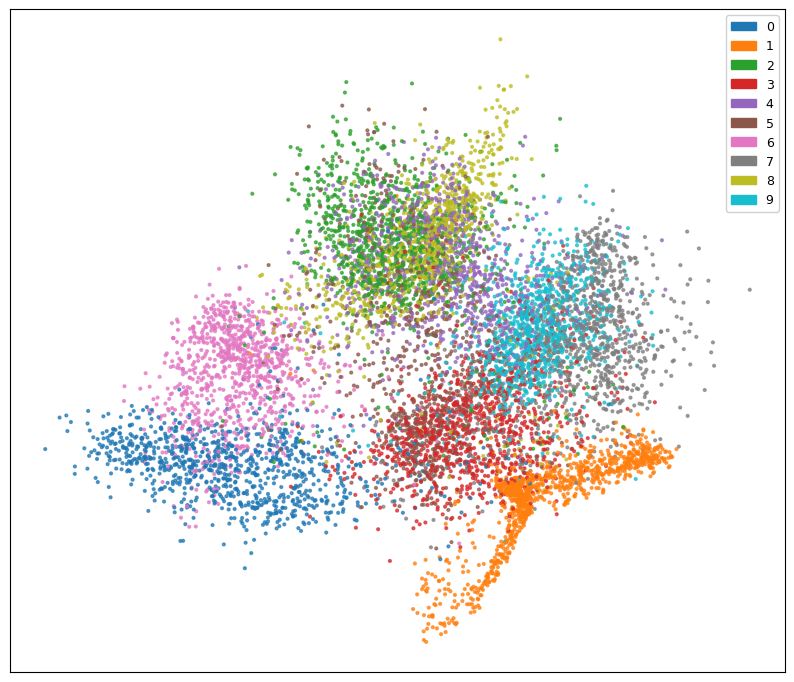

In [31]:
# ---------------------------------------------------------------
#  Visualising the Dimensionality-Reduction AAE embedding
#  (Figure-11 style: panels a–d)
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from tqdm import tqdm
from sklearn.manifold import TSNE

model   = model                             
loader  = test_loader                        
device  = torch.device("cuda:0")            


Z, colours = [], []
model.eval()
with torch.no_grad():
    for x, y in tqdm(loader):
        x = x.to(device)
        z_batch = model.embed(x)             # (B, n)  ← new helper!
        Z.append(z_batch.cpu())
        colours.append(y.cpu())              # true digit label

Z       = torch.cat(Z).numpy()               # (N, n)
colours = torch.cat(colours).numpy()

# ----------------------------------------------------------------
# If n == 2  → direct scatter;  else project to 2-D first
# ----------------------------------------------------------------
if Z.shape[1] == 2:
    Z2 = Z
else:
    Z2 = TSNE(n_components=2, perplexity=30).fit_transform(Z)

# ----------------------------------------------------------------
# Plot
# ----------------------------------------------------------------
plt.figure(figsize=(10,10))
plt.scatter(Z2[:,0], Z2[:,1], c=colours, s=4, cmap='tab10', alpha=.7)
handles = [mpatches.Patch(color=plt.cm.tab10(i), label=str(i)) for i in range(10)]

plt.legend(handles=handles,
           loc='upper right',
           prop={'size': 9},
           framealpha=.9)
plt.gca().set(aspect='equal', xticks=[], yticks=[])
# title = (f"{Z.shape[1]}-D representation "
#          f"(10 labels)")
# plt.title(title)
plt.show()
